In [2]:
import os
import glob

import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.neighbors import KDTree

In [ ]:
obs_files = glob.glob("../OUTPUT/*csv")
idx_lsit = []
concat_df_dict = {}
for obs_file in obs_files:
    file_info = obs_file.split("\\")[-1].split('_')
    road_name, road_dir = file_info[1],file_info[2]

    road_info_file = glob.glob(f'C:/Users/user/Desktop/DB/ROAD/서울&시흥_road_shp/**/*{road_name}_{road_dir}*shp', recursive=True)[0]


    dongbu_d_df = pd.read_csv(obs_file)
    road_info = gpd.read_file(road_info_file, encoding = 'cp949')
    try :
        road_info = road_info[['LANES', 'ROAD_RANK', 'ROAD_TYPE', 'ROAD_USE', 'MULTI_LINK', 'CONNECT', 'MAX_SPD', 'long', 'lat']]
    except:
        road_info = road_info[['LANES', 'ROAD_RANK', 'ROAD_TYPE', 'ROAD_USE', 'MULTI_LINK', 'CONNECT', 'MAX_SPD', 'long_mid','lat_mid']]	
        road_info = road_info.rename({'long_mid':'long','lat_mid':'lat'}, axis = 1)
    road_info = road_info.dropna()

    observ_line = np.array(list(zip(road_info['long'], road_info['lat'])))
    model_line = np.array(list(zip(dongbu_d_df['longitude'], dongbu_d_df['latitude'])))

    tree = KDTree(observ_line)
    # 각 점마다 가장 가까운 점을 찾아 매칭

    matched_points = []
    for point in model_line:
        _, index = tree.query([point], k=1)  # k=1로 설정하여 가장 가까운 점 하나만 선택
        matched_points.append(observ_line[index[0]])

    matched_lon = [point[0][0] for point in matched_points]
    matched_lat = [point[0][1] for point in matched_points]

    df = pd.DataFrame({'longitude': model_line[:, 0], 'latitude': model_line[:, 1],
                        'long_match': matched_lon, 'lat_match': matched_lat})

    unique_coords = df[['longitude', 'latitude','long_match','lat_match']].drop_duplicates()

    total_df = pd.merge(unique_coords,dongbu_d_df, on=['longitude','latitude'], how='right')
    road_info = road_info.rename({'long':'long_match','lat':'lat_match'}, axis = 1)
    total_df = pd.merge(total_df, road_info, on=['long_match', 'lat_match'], how='left')
    print(obs_file)
    concat_df_dict[f"{obs_file}"] = total_df
    file_name = obs_file.split('\\')[-1]
    total_df.to_csv(f'../OUTPUT/도로구조병합/{file_name}', index=False)
    idx_lsit.append(f"{obs_file}")
    del road_info_file, total_df, road_info


In [43]:
road_info = gpd.read_file('C:/Users/user/Desktop/DB/ROAD/서울&시흥_road_shp/seoul/olympic_DLR.shp', encoding = 'cp949')

In [47]:
road_info

,OBJECTID_1,LINK_ID,F_NODE,T_NODE,LANES,ROAD_RANK,ROAD_TYPE,ROAD_NO,ROAD_USE,MULTI_LINK,...,District,DO,SIGU,OBJECTID,ROAD_NAME,Shape_Leng,Shape_Le_1,long,lat,geometry
0,361.0,1180133101,1180048400,1180074001,5,102,000,88,0,0,...,118,seoul,None,0.0,None,0.0,696.702243,126.912812,37.523628,"LINESTRING (126.91098 37.52641, 126.91124 37.5..."
1,363.0,1180133201,1180074001,1190022000,4,102,000,88,0,0,...,118,seoul,None,0.0,None,0.0,1321.204728,126.920410,37.517115,"LINESTRING (126.91472 37.52089, 126.91545 37.5..."
2,366.0,1220345801,1220158901,1220002200,4,102,000,88,0,0,...,122,seoul,None,0.0,None,0.0,246.164224,127.063714,37.519553,"LINESTRING (127.06276 37.52033, 127.06274 37.5..."
3,367.0,1150002301,1150040800,1150035700,4,102,000,88,0,0,...,115,seoul,None,0.0,None,0.0,738.158181,126.858860,37.565408,"LINESTRING (126.85549 37.56738, 126.85663 37.5..."
4,368.0,1150002302,1150035700,1150032800,4,102,000,88,0,0,...,115,seoul,None,0.0,None,0.0,405.546903,126.864092,37.562381,"LINESTRING (126.86225 37.56347, 126.86369 37.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,479.0,1240050600,1240024100,1240090200,4,102,000,88,0,0,...,124,seoul,gangdong-gu,0.0,None,0.0,841.525625,127.128046,37.560482,"LINESTRING (127.12572 37.55708, 127.12611 37.5..."
61,480.0,1220345901,1220053300,1220158901,6,102,000,88,0,0,...,122,seoul,None,0.0,None,0.0,564.606202,127.060966,37.522516,"LINESTRING (127.05849 37.52394, 127.05861 37.5..."
62,NaN,1150437400,1150149100,1150149200,3,102,000,88,0,0,...,None,None,None,NaN,占쏙옙占쏙옙占싼곤옙占쏙옙,NaN,NaN,NaN,NaN,"LINESTRING (126.79867 37.59598, 126.79874 37.5..."
63,NaN,1150111600,1150053500,1150053800,3,102,000,88,0,0,...,None,None,None,NaN,占쏙옙占쏙옙占싼곤옙占쏙옙,NaN,NaN,NaN,NaN,"LINESTRING (126.80095 37.59387, 126.80250 37.5..."


<Axes: >

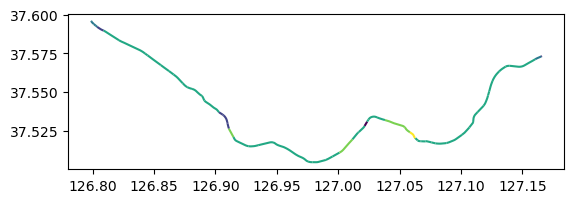

In [49]:
road_info.plot("LANES")

In [ ]:
for i in range(len(idx_lsit)):
    print(concat_df_dict[idx_lsit[i]].columns)

In [4]:
from sklearn import metrics

In [40]:
for i in idx_lsit:
    df = concat_df_dict[i]

    for road in df['road_name'].unique():
        for hour in df['ROAD_RANK'].unique():
            try:
                df_hour = df[(df['road_name']==road) & (df['ROAD_RANK']==hour)]
                print(road , hour)
                print(metrics.mean_squared_error(df_hour['surface_temperature'],df_hour['org']), end = "|")
                print(metrics.mean_squared_error(df_hour['surface_temperature'],df_hour['yc']), end = "|")
                print(metrics.mean_squared_error(df_hour['surface_temperature'],df_hour['mg']), end = "|")
                print(metrics.mean_squared_error(df_hour['surface_temperature'],df_hour['jr']), end = "|")
                print(metrics.mean_squared_error(df_hour['surface_temperature'],df_hour['ss']), end = "|")
                print()
                # print(df_hour.value_counts('closest_column'))
            except:
                print()

dongbu 102
14.45834237731093|0.7942782668620778|19.176037796887833|20.85242992397612|0.9138040933134924|
dongbu 102
6.297939255344055|25.353831756336263|3.937838986953362|4.130976588627521|26.0082453477543|
dongbu 102
2.9488555926639406|14.529759847793818|11.42264312824799|3.7408005392025925|18.393160032111403|
gangbyeon 102
2.025411965524932|1.7721264258023348|51.775160979322855|19.68100211667733|0.8955472975694208|
naebu 102
7.598301631543224|9.253396863415924|67.58927118450438|32.90349161641739|6.877355573252725|
olympic 102
2.3386136613357955|7.691050858375529|6.559775345324782|8.759284319669135|7.765990495029804|
olympic 102
3.4911369401763728|15.960281272362597|5.4294382382340665|6.638993451810344|16.181856670176042|
olympic 102
4.217724944782698|8.195163646582523|8.303930787715334|7.937630903746705|8.885886139752575|
olympic 102
9.292622275256695|4.741695745509457|10.887542538173381|12.336197681233447|5.008623231312452|
olympic 102
11.780149353861301|2.9805541815859034|15.145707

In [56]:
file_info = obs_file[0].split("\\")[-1].split('_')
road_name, road_dir = file_info[1],file_info[2]

road_info_file = glob.glob(f'C:/Users/user/Desktop/DB/ROAD/서울&시흥_road_shp/seoul/*{road_name}_{road_dir}*shp')[0]

In [57]:
dongbu_d_df = pd.read_csv(glob.glob("./OUTPUT/*csv")[0])

In [58]:
road_info = gpd.read_file(road_info_file, encoding = 'cp949')

In [ ]:
# road_info_1 = road_info[['LANES', 'ROAD_RANK', 'ROAD_TYPE', 'ROAD_USE', 'MULTI_LINK', 'CONNECT', 'MAX_SPD', 'long', 'lat']]
# road_info_1 = road_info_1.dropna()

# observ_line = np.array(list(zip(road_info_1['long'], road_info_1['lat'])))
# model_line = np.array(list(zip(dongbu_d_df['longitude'], dongbu_d_df['latitude'])))

# tree = KDTree(observ_line)
# # 각 점마다 가장 가까운 점을 찾아 매칭

# matched_points = []
# for point in model_line:
#     _, index = tree.query([point], k=1)  # k=1로 설정하여 가장 가까운 점 하나만 선택
#     matched_points.append(observ_line[index[0]])

# matched_lon = [point[0][0] for point in matched_points]
# matched_lat = [point[0][1] for point in matched_points]

# df = pd.DataFrame({'longitude': model_line[:, 0], 'latitude': model_line[:, 1],
#                        'long_match': matched_lon, 'lat_match': matched_lat})

# unique_coords = df[['longitude', 'latitude','long_match','lat_match']].drop_duplicates()

# total_df = pd.merge(unique_coords,dongbu_d_df, on=['longitude','latitude'], how='right')
# road_info_1 = road_info_1.rename({'long':'long_match','lat':'lat_match'}, axis = 1)
# total_df = pd.merge(total_df, road_info_1, on=['long_match', 'lat_match'], how='left')

In [14]:
road_arc_file_list = glob.glob('../OUTPUT/도로구조병합/*csv')

In [ ]:
dfs_list = []
for i in road_arc_file_list:
    df = pd.read_csv(i)
    df = df[['timestamp','longitude','latitude','long_match','lat_match','surface_temperature','jr','mg','org','ss','yc','closest_column',
'LANES','ROAD_RANK','ROAD_TYPE','ROAD_USE','MULTI_LINK','CONNECT','MAX_SPD']]
    dfs_list.append(df)

dfs = pd.concat(dfs_list)

In [41]:
dfs['ROAD_TYPE'].unique()

array([0, 3, 2, 1], dtype=int64)

In [37]:
df_acr = dfs[dfs['ROAD_TYPE'] == 1]

print(metrics.mean_squared_error(df_acr['surface_temperature'],df_acr['org']), end = "|")
print(metrics.mean_squared_error(df_acr['surface_temperature'],df_acr['yc']), end = "|")
print(metrics.mean_squared_error(df_acr['surface_temperature'],df_acr['mg']), end = "|")
print(metrics.mean_squared_error(df_acr['surface_temperature'],df_acr['jr']), end = "|")
print(metrics.mean_squared_error(df_acr['surface_temperature'],df_acr['ss']), end = "|")
print()


21.175498168549495|1.3947017613443662|41.94575974671219|30.348620446724176|1.077507023248607|
